In [2]:
import pandas as pd
import numpy as np
import allel
import matplotlib.pyplot as plt

In [6]:
root = "/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/"
#let's import the file with the snps that clement-ziza et al from /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/QTL mapping/SupplementaryDataset_S7_genotype.tsv
cz_snps=pd.read_csv(root + 'Bence folder/QTL mapping/SupplementaryDataset_S7_genotype.tsv',sep='\t',header=15)
#let's import the vcf file with the snps that we called
jb759_snps=allel.read_vcf("/Users/bencekover/bioinformatics/projects/snp_jb759/results_raw.vcf",fields=['samples','variants/CHROM','variants/POS','calldata/GT'])
jb50_snps=allel.read_vcf("/Users/bencekover/bioinformatics/projects/snp_jb50/results_raw.vcf",fields=['samples','variants/CHROM','variants/POS','calldata/GT'])
#lets import the vcf for our control strain R4 /Users/bencekover/bioinformatics/projects/segregants/40-798766616/00_fastq/R4_raw_snps.vcf
r4_snps = allel.read_vcf("/Users/bencekover/bioinformatics/projects/segregants/40-798766616/00_fastq/R4_raw_snps.vcf",fields=['samples','variants/CHROM','variants/POS','calldata/GT'])



In [7]:

jb759__chrom=jb759_snps['variants/CHROM']
jb759__pos=jb759_snps['variants/POS']
jb759__gt=jb759_snps['calldata/GT']
#retian only the chrom and pos values where calldata/GT is [1,1]
index = np.where(jb759__gt == [1,1])
index = np.unique(index[0])
jb759__chrom_=jb759__chrom[index]
jb759__pos_=jb759__pos[index]
#repeat for r4
r4__chrom=r4_snps['variants/CHROM']
r4__pos=r4_snps['variants/POS']
r4__gt=r4_snps['calldata/GT']
#retian only the chrom and pos values where calldata/GT is [1,1]
index = np.where(r4__gt == [1,1])
index = np.unique(index[0])
r4__chrom_=r4__chrom[index]
r4__pos_=r4__pos[index]


In [8]:
cz__pos= cz_snps["position"]
cz_r4_snps_index = cz_snps["R1_4"]
cz_r4_snps_index = cz__pos[cz_r4_snps_index == 1]

In [9]:
#find overlap between r4__pos_ and cz_r4_snps_index
overlapping_pos = np.intersect1d(r4__pos_, cz_r4_snps_index)
#print the the ratio of overalps compared to the number of snps called bu cz
print(len(overlapping_pos)/len(cz_r4_snps_index))

0.9521819870009285


# Reconstructing the genotype matrix

In [10]:
#saving the snp coordinates of calls in the original genotype matrix
cz_chrom = cz_snps["chromosome"]
cz_pos = cz_snps["position"]
cz_alt_allele = cz_snps["Y0036_allele"]
cz_ref_allele = cz_snps["968_allele"]
#loading the vcf file with the snps that we called: /Users/bencekover/bioinformatics/projects/segregants/cohort.vcf
bk_vcf = allel.read_vcf("/Users/bencekover/bioinformatics/projects/segregants/cohort.vcf",fields=['samples','variants/CHROM','variants/REF','variants/POS','variants/ALT','calldata/GT'])
samples = bk_vcf['samples']
chrom = bk_vcf['variants/CHROM']
pos = bk_vcf['variants/POS']
gt = bk_vcf['calldata/GT']
alt = bk_vcf['variants/ALT']
ref =  bk_vcf['variants/REF']
# Make new columns R1_34, R1_44, R1_45, R1_48, R1_49, R1_50, R1_51, R1_52, R1_53, R1_54. Fill them up with nan
cz_snps["R1_34"] = np.nan
cz_snps["R1_44"] = np.nan
cz_snps["R1_45"] = np.nan
cz_snps["R1_48"] = np.nan
cz_snps["R1_49"] = np.nan
cz_snps["R1_50"] = np.nan
cz_snps["R1_51"] = np.nan
cz_snps["R1_52"] = np.nan
cz_snps["R1_53"] = np.nan
cz_snps["R1_54"] = np.nan
cz_snps["R1_4_2"] = np.nan
cz_snps["JB759"] = np.nan
cz_snps["JB50"] = np.nan

#in chrom replace I II III with chromosome_1, chromosome_2, chromosome_3
chrom = np.where(chrom == "I", "chromosome_1", chrom)
chrom = np.where(chrom == "II", "chromosome_2", chrom)
chrom = np.where(chrom == "III", "chromosome_3", chrom)

In [11]:
new_samples = ["R34","R44","R45","R48","R49","R50","R51","R52","R53","R54","R4","JB759","JB50"]
sample_colnames = ["R1_34","R1_44","R1_45","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54","R1_4_2","JB759","JB50"]
#loop through the samples
for i,k in zip(new_samples,sample_colnames):
      #find the index of the sample in the vcf file
      sample_index = np.where(samples == i)[0]
      #find the chrom and pos values of the snps that we called for this sample
      sample_calls = gt[:,sample_index,:][:,0,:]
      #iterate through the length of cz_pos 
      for j in range(len(cz_pos)):
            #find the index of the snp in the vcf file
            snp_index = np.where((chrom == cz_chrom[j]) & (pos == cz_pos[j]))[0]
            #find the genotype of the snp in the vcf file
            #if snp is not in vcf then snp_call = nan
            final_snp_call = 0
            if (len(snp_index) != 0):
                  snp_index = snp_index[0]
                  if sample_calls[snp_index,0]==sample_calls[snp_index,1]:
                        snp_call = sample_calls[snp_index,0]
                        if snp_call >3:
                              continue
                        if snp_call == 0:
                              snp_genotype = ref[snp_index]
                        elif snp_call >0:

                              snp_genotype = alt[snp_index][snp_call-1]
                        if snp_genotype == cz_alt_allele[j]:
                              
                              final_snp_call = 1
                        elif snp_genotype == cz_ref_allele[j]:
                              final_snp_call = 0
                        elif (snp_genotype != cz_alt_allele[j] and snp_genotype != cz_ref_allele[j]):
                              final_snp_call = 2
                              print(2)
                  else:

                        final_snp_call = np.nan
            
            cz_snps[k][j] = final_snp_call
      print("new_sample")

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_36418/1002686202.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cz_snps[k][j] = final_snp_call


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample


In [12]:
cz_snps.head()

,chromosome,position,968_allele,Y0036_allele,968,Y0036,R1_1,R1_2,R1_3,R1_4,...,R1_48,R1_49,R1_50,R1_51,R1_52,R1_53,R1_54,R1_4_2,JB759,JB50
0,chromosome_1,54120,A,G,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,chromosome_1,60438,C,T,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,chromosome_1,71120,A,G,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,chromosome_1,74490,CTT,C,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,chromosome_1,78435,G,A,0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [13]:
#now filling in some of the missing values be assuming continous haplotypes
#iterate through sample_colnames
#if there is a nan that is preceded and followed by a 1 then fill in the nan with a 1 or if there is a nan that is preceded and followed by a 0 then fill in the nan with a 0
#
for i in sample_colnames:
      #find the indices of the nan values
      nan_indices = np.where(np.isnan(cz_snps[i]))[0]
      for j in nan_indices:
            if j == 4480:
                  continue

            if (cz_snps[i][j-1] == 1) & (cz_snps[i][j+1] == 1):
                  cz_snps[i][j] = 1
            elif (cz_snps[i][j-1] == 0) & (cz_snps[i][j+1] == 0):
                  cz_snps[i][j] = 0
            else:
                  continue


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_36418/4160173796.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cz_snps[i][j] = 1
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_36418/4160173796.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cz_snps[i][j] = 0


In [15]:
46/len(cz_snps)

0.010265565721937068

array([   0., 4481., 1129., 3395., 2655., 2154., 3397., 1098., 2327.,
       1235., 2284., 1260., 2948., 2122., 1562., 3076., 2612., 2876.,
       2024., 1759., 1476., 1782., 1254., 2813., 1090., 2527., 2124.,
        522., 1940.,  847., 2005., 2129., 2509., 2355., 1579., 1632.,
       1728., 2352., 1201., 3249., 2058., 1536., 1398., 2551., 2198.,
       1899., 2322., 3160., 2204.,   35.,  739., 1428., 1152., 3612.,
       2166., 1944., 2202., 4456.,   46.])

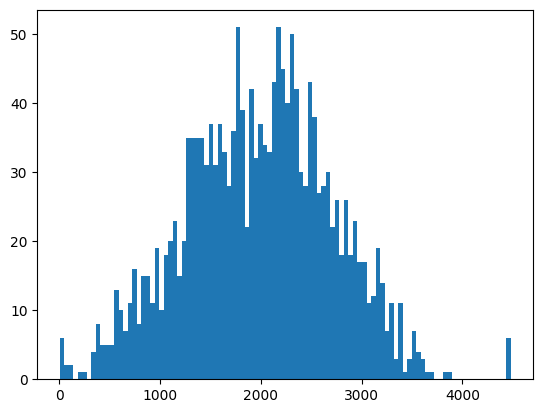

In [16]:
# Measuring L1 distance between all strains
#ceate a strain by strain matrix
#iterate through the strains and fill in the matrix with the L1 distance between the strains
all_strains =  cz_snps.columns[4:]
s_by_s_matrix = np.zeros((len(all_strains),len(all_strains)))
for i in range(len(all_strains)):
      for j in range(len(all_strains)):
            values_i = cz_snps[all_strains[i]]
       
            values_j = cz_snps[all_strains[j]]
           
            s_by_s_matrix[i,j] = np.sum(np.abs(values_i-values_j))
s_by_s_matrix
#show distribution of L2 distances except the diagonal
plt.hist(s_by_s_matrix[np.triu_indices(len(all_strains),k=1)], bins=100)
#print array of values between strains in sample_colnames and all other strains
s_by_s_matrix[np.where(all_strains == "968")[0],:][0]

      

In [17]:
s_by_s_matrix[np.where(all_strains == "R1_4")[0],:][0]

array([2154., 2243., 1498., 2499., 2820.,    0., 1917., 2722., 1596.,
       2217., 1590., 1919., 1877., 3362., 2956., 2491., 3185., 2424.,
       2916., 2642., 2439., 2778., 2477., 2153., 2412., 3270., 2469.,
       2180., 2842., 1945., 3214., 3174., 3528., 3478., 2514., 2566.,
       2614., 3123., 1765., 2676., 3130., 1426., 2674., 2085., 2654.,
       3276., 1405., 2596.,   47., 2165.,  958., 1317., 1368., 2191.,
       2744., 1248.,   44., 2266., 2172.])

In [20]:
#write code that shows which pairs of strains have a value below 100 except pairs with itself
for i in range(len(all_strains)):
      for j in range(len(all_strains)):
            if (s_by_s_matrix[i,j] < 100) & (i != j):
                  print(all_strains[i], all_strains[j], s_by_s_matrix[i,j])
      

#It was based on this analysis that we decided to remove R48 and R45 from downstream analysis

968 R1_48 35.0
968 JB50 46.0
Y0036 JB759 84.0
R1_4 R1_45 47.0
R1_4 R1_4_2 44.0
R1_17 R1_50 97.0
R1_44 R1_50 71.0
R1_45 R1_4 47.0
R1_45 R1_4_2 6.0
R1_48 968 35.0
R1_48 JB50 40.0
R1_50 R1_17 97.0
R1_50 R1_44 71.0
R1_4_2 R1_4 44.0
R1_4_2 R1_45 6.0
JB759 Y0036 84.0
JB50 968 46.0
JB50 R1_48 40.0


In [21]:
s_by_s_matrix[np.where(all_strains == "JB50")[0],:][0]

array([  46., 4475., 1154., 3400., 2670., 2172., 3402., 1125., 2343.,
       1260., 2309., 1285., 2958., 2134., 1588., 3090., 2617., 2882.,
       2037., 1777., 1496., 1799., 1284., 2828., 1115., 2540., 2139.,
        559., 1953.,  881., 2019., 2149., 2525., 2372., 1600., 1663.,
       1745., 2367., 1227., 3255., 2072., 1561., 1423., 2565., 2217.,
       1921., 2319., 3161., 2208.,   40.,  738., 1422., 1151., 3608.,
       2160., 1950., 2210., 4450.,    0.])

In [22]:
np.sum(np.abs(cz_snps["R1_4"]-cz_snps["R1_4_2"]))

44.0

In [23]:
np.unique(cz_snps["JB50"], return_counts=True)


(array([0., 1., 2.]), array([4455,    6,   20]))

In [24]:
np.unique(cz_snps["JB759"], return_counts=True)

(array([ 0.,  1.,  2., nan]), array([  54, 4396,   30,    1]))

In [25]:
np.unique(cz_snps["R1_4_2"], return_counts=True)

(array([ 0.,  1.,  2., nan]), array([2291, 2172,   15,    3]))

# Calling the uncalled SNPs

In [26]:
#find index of entries in chrom with chromosome_1 or chromosome_2 or chromosome_3
chromosome_index = np.where((chrom == "chromosome_1") | (chrom == "chromosome_2") | (chrom == "chromosome_3"))[0]
chrom_new = chrom[chromosome_index]
pos_new = pos[chromosome_index]
ref_new = ref[chromosome_index]
alt_new = alt[chromosome_index]
gt_new = gt[chromosome_index,:,:]


In [27]:
#iterate through the callsets first dimension, merge the last two dimensions and print it
indices = []
jb50_values = []
jb759_values = []
alt_new_final = []
ref_new_final = []
for i in range(len(gt_new)):
      calls = np.concatenate(gt_new[i,:,:], axis=0)
      #if calls have at most 2 -1 values and at most half of the values are not 0, then print the array and save index and JB50 is the same as R1_48

      if (pos_new[i] not in cz_pos.values) & (calls[0] == calls[1]) & (calls[2] == calls[3]) & (calls[0] != -1) & (calls[2] != -1) & (calls[0] != calls[2]) & (calls[0] == calls[12]) & (calls[1] == calls[13]):
            
            jb50_call = calls[0]
            jb759_call = calls[2]
            
            if jb50_call == 0:
                  indices.append(i)
                  jb50_values.append(jb50_call)
                  jb759_values.append(jb759_call)
                  ref_new_final.append(ref_new[i])
                  alt_new_final.append(alt_new[i][jb759_call-1])
            elif jb759_call == 0:
                  indices.append(i)
                  jb50_values.append(jb50_call)
                  jb759_values.append(jb759_call)
                  alt_new_final.append(ref_new[i])
                  ref_new_final.append(alt_new[i][jb50_call-1])
            
            
            print(calls)
            

#keep the chromosomes and positions that we want to keep
chrom_new_final = chrom_new[indices]
pos_new_final = pos_new[indices]



[0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1]
[0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1]
[0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1]
[0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1]
[0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1]
[0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1]
[0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1]
[0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1]
[0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1]
[0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1]
[0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0

In [28]:
#append the new chromosomes and positions to the old ones in cz snps
#create an add on dataframe and then concat it to the old one
cz_snps_addon = pd.DataFrame(index=range(len(chrom_new_final)), columns=cz_snps.columns)
cz_snps_addon["chromosome"] = chrom_new_final
cz_snps_addon["position"] = pos_new_final
cz_snps_addon["968_allele"] = ref_new_final
cz_snps_addon["Y0036_allele"] = alt_new_final
cz_snps_addon["968"] = jb50_values
cz_snps_addon["Y0036"] = jb759_values

In [29]:
#average length of alt_new_final
sum([len(i) for i in alt_new_final])/len(alt_new_final)
#average length of ref_new_final
sum([len(i) for i in ref_new_final])/len(ref_new_final)

2.603960396039604

In [30]:
#calculate how many of alt_new_final has a length longer than 1
n_indels = 0
for i in alt_new_final:
    if len(i)>1:
        n_indels +=1
for i in ref_new_final:
    if len(i)>1:
        n_indels += 1

In [31]:
n_indels 

132

In [32]:
#calculate same for cz_snps
sum([len(i) for i in cz_snps["968_allele"]])/len(cz_snps["968_allele"])
sum([len(i) for i in cz_snps["Y0036_allele"]])/len(cz_snps["Y0036_allele"])

1.1557688016067842

In [34]:
#merge with the old dataframe
cz_snps_final = pd.concat([cz_snps, cz_snps_addon], axis=0, ignore_index=True)
#order based on chromosome and position
cz_snps_final = cz_snps_final.sort_values(by=["chromosome", "position"])
#reset index
cz_snps_final = cz_snps_final.reset_index(drop=True)
cz_snps_final.head()

,chromosome,position,968_allele,Y0036_allele,968,Y0036,R1_1,R1_2,R1_3,R1_4,...,R1_48,R1_49,R1_50,R1_51,R1_52,R1_53,R1_54,R1_4_2,JB759,JB50
0,chromosome_1,16608,A,G,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chromosome_1,23331,C,A,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chromosome_1,49259,T,C,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chromosome_1,49262,C,T,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chromosome_1,49265,C,T,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
new_samples = ["R34","R44","R45","R48","R49","R50","R51","R52","R53","R54","R4","JB759","JB50"]
sample_colnames = ["R1_34","R1_44","R1_45","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54","R1_4_2","JB759","JB50"]
cz_snps_final_pos= cz_snps_final["position"]
cz_snps_final_chrom = cz_snps_final["chromosome"]
cz_snps_final_alt = cz_snps_final["Y0036_allele"]
cz_snps_final_ref = cz_snps_final["968_allele"]
#loop through the samples
for i,k in zip(new_samples,sample_colnames):
      #find the index of the sample in the vcf file
      sample_index = np.where(samples == i)[0]
      #find the chrom and pos values of the snps that we called for this sample
      sample_calls = gt[:,sample_index,:][:,0,:]
      #iterate through the length of cz_pos 
      for j in range(len(cz_snps_final_pos)):
            #find the index of the snp in the vcf file
            snp_index = np.where((chrom == cz_snps_final_chrom[j]) & (pos == cz_snps_final_pos[j]))[0]
            #find the genotype of the snp in the vcf file
            #if snp is not in vcf then snp_call = nan
            final_snp_call = 0
            if (len(snp_index) != 0):
                  snp_index = snp_index[0]
                  if sample_calls[snp_index,0]==sample_calls[snp_index,1]:
                        snp_call = sample_calls[snp_index,0]
                        if snp_call >3:
                              continue
                        if snp_call == 0:
                              snp_genotype = ref[snp_index]
                        elif snp_call >0:

                              snp_genotype = alt[snp_index][snp_call-1]
                        if snp_genotype == cz_snps_final_alt[j]:
                              
                              final_snp_call = 1
                        elif snp_genotype == cz_snps_final_ref[j]:
                              final_snp_call = 0
                        elif (snp_genotype != cz_snps_final_alt[j] and snp_genotype != cz_snps_final_ref[j]):
                              final_snp_call = 2
                              print(2)
                  else:

                        final_snp_call = np.nan
            
            cz_snps_final[k][j] = final_snp_call
      print("new_sample")

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_36418/3765786204.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cz_snps_final[k][j] = final_snp_call


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
new_sample


In [36]:
cz_snps_final.head()

,chromosome,position,968_allele,Y0036_allele,968,Y0036,R1_1,R1_2,R1_3,R1_4,...,R1_48,R1_49,R1_50,R1_51,R1_52,R1_53,R1_54,R1_4_2,JB759,JB50
0,chromosome_1,16608,A,G,0,1,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,chromosome_1,23331,C,A,0,1,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2,chromosome_1,49259,T,C,0,1,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,chromosome_1,49262,C,T,0,1,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,chromosome_1,49265,C,T,0,1,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [37]:
#now filling in some of the missing values be assuming continous haplotypes
#iterate through sample_colnames
#if there is a nan that is preceded and followed by a 1 then fill in the nan with a 1 or if there is a nan that is preceded and followed by a 0 then fill in the nan with a 0
all_strains = cz_snps_final.columns[4:].values
printer = 0
for i in all_strains:
      
      #find the indices of the nan values
      nan_indices = np.where(np.isnan(cz_snps_final[i]))[0]
      for j in nan_indices:
           
            if j == 4884 or j == 0:
                  continue

            if (cz_snps_final[i][j-1] == 1) & (cz_snps_final[i][j+1] == 1):
                  cz_snps_final[i][j] = 1
                  
            elif (cz_snps_final[i][j-1] == 0) & (cz_snps_final[i][j+1] == 0):
                  cz_snps_final[i][j] = 0
                  printer += 1
                  print(printer)
      



/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_36418/742283186.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cz_snps_final[i][j] = 1
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_36418/742283186.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cz_snps_final[i][j] = 0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [41]:
#save the new matrix as .tsv
#turn all 2 values to nan
cz_snps = cz_snps.replace(2, np.nan)
#remove R4_2
cz_snps = cz_snps.drop(columns=["R1_4_2"])
#remove jb50
cz_snps = cz_snps.drop(columns=["JB50"])
cz_snps = cz_snps.drop(columns=["JB759"])
#r45 and 48
cz_snps = cz_snps.drop(columns=["R1_45"])
cz_snps = cz_snps.drop(columns=["R1_48"])
#cz_snps.to_csv("/Users/bencekover/bioinformatics/projects/segregants/updated_genotype_matrix.tsv", sep="\t", index=False)

In [42]:
#repeat for cz_snps_final_pos
cz_snps_final= cz_snps_final.replace(2, np.nan)
cz_snps_final = cz_snps_final.drop(columns=["R1_4"])
#rename column R1_4_2 to R1_4
cz_snps_final = cz_snps_final.rename(columns={"R1_4_2": "R1_4"})

cz_snps_final = cz_snps_final.drop(columns=["JB50"])
cz_snps_final = cz_snps_final.drop(columns=["JB759"])
cz_snps_final = cz_snps_final.drop(columns=["R1_45"])
cz_snps_final = cz_snps_final.drop(columns=["R1_48"])
#cz_snps_final.to_csv("/Users/bencekover/bioinformatics/projects/segregants/updated_genotype_matrix_final_pos.tsv", sep="\t", index=False)


In [43]:
%load_ext watermark
%watermark


Last updated: 2023-11-05T14:50:20.761722+00:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [44]:
%watermark --iversions



pandas    : 1.4.4
allel     : 1.3.5
numpy     : 1.23.4
matplotlib: 3.8.0

